In [1]:
# ! pip3 install --no-cache https://developer.download.nvidia.com/compute/redist/jp/v61/pytorch/torch-2.5.0a0+872d972e41.nv24.08.17622132-cp310-cp310-linux_aarch64.whl
# ! pip install --no-deps "torchvision==0.20.0"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v3_large
import math
import cv2, numpy as np
import tensorrt as trt
import pycuda.driver as cuda
import numpy as np
from flask import Flask, Response

In [3]:
print(torch.__version__)

#device check / setting
device = "cuda" if torch.cuda.is_available() else "cpu"

print("CUDA available:", torch.cuda.is_available())
print("Device being used:", device)
if device == "cuda":
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Current CUDA device index:", torch.cuda.current_device())

2.3.0
CUDA available: True
Device being used: cuda
GPU Name: Orin
Current CUDA device index: 0


In [4]:
# # ONNX Conversion

# #Model definition
# class Model(nn.Module):
#     def __init__(self):
#         super().__init__()
#         #MobileNetV3 backbone
#         mnet = mobilenet_v3_large(weights="DEFAULT")
#         self.backbone = mnet.features #(B, 960, H/32, W/32)
        
#         self.deconv = nn.Sequential(
#             nn.ConvTranspose2d(960, 256, 4, 2, 1), # */16
#             nn.BatchNorm2d(256), nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(256, 256, 4, 2, 1), # */8
#             nn.BatchNorm2d(256), nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(256, 256, 4, 2, 1), # */8
#             nn.BatchNorm2d(256), nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(256, 256, 4, 2, 1), # */8
#             nn.BatchNorm2d(256), nn.ReLU(inplace=True)
#         )
#         self.head = nn.Conv2d(256, 21, 1)
        
    
#     def forward(self, x):
#         x = self.backbone(x)
#         x = self.deconv(x)
#         return self.head(x)

# # Load model
# model = Model()
# model = model.to("cuda")
# ckpt = torch.load("heatmap_4deconv.pth", map_location="cpu")
# model.load_state_dict(ckpt['model'])
# model.eval()

# # dummy input
# dummy_input = torch.randn(1, 3, 224, 224, device = "cuda")

# # ONNX export
# torch.onnx.export(
#     model, 
#     dummy_input, 
#     "heatmap_4deconv.onnx", 
#     input_names=["input"], 
#     output_names=["output"],
#     opset_version=11
# )

# print("ONNX genterated")


ONNX genterated


In [5]:
# # onnx -> tensorrt
# import os

# cmd = "/usr/src/tensorrt/bin/trtexec --onnx=heatmap_4deconv.onnx --saveEngine=heatmap_4deconv_fp16.engine --fp16"
# os.system(cmd)

In [6]:
# device check
!ls -ltrh /dev/video*

crw-rw----+ 1 root video 81, 0 Dec 31  1969 /dev/video0
crw-rw----+ 1 root video 81, 1 Dec 31  1969 /dev/video1


In [7]:
# import tensorrt as trt, pycuda.driver as cuda
import numpy as np, cv2
from flask import Flask, Response
import pycuda.driver as cuda
import glob, random
import matplotlib.pyplot as plt
import tensorrt as trt
from torchvision import transforms
from PIL import Image

random.seed(99)

# --- CUDA / TRT basic setting ---
cuda.init()
dev = cuda.Device(0)
ctx = dev.retain_primary_context()
ctx.push()

TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
with open("heatmap_4deconv_fp16.engine", "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
    engine = runtime.deserialize_cuda_engine(f.read())
context = engine.create_execution_context()

# I / O search
n_io = engine.num_io_tensors
names = [engine.get_tensor_name(i) for i in range(n_io)]
inputs  = [n for n in names if engine.get_tensor_mode(n) == trt.TensorIOMode.INPUT]
outputs = [n for n in names if engine.get_tensor_mode(n) == trt.TensorIOMode.OUTPUT]
assert len(inputs) == 1 and len(outputs) == 1, f"Unexpected IO tensors: in={inputs}, out={outputs}"
in_name, out_name = inputs[0], outputs[0]

# shape
in_h, in_w = 224, 224
context.set_input_shape(in_name, (1, 3, in_h, in_w))  # ★ 동적 입력 shape 지정

# dtype/shape check
in_dtype  = trt.nptype(engine.get_tensor_dtype(in_name))
out_shape = tuple(context.get_tensor_shape(out_name))  # e.g. (1, K, H, W)
out_dtype = trt.nptype(engine.get_tensor_dtype(out_name))

# Memory allocation / mapping
nbytes_in  = int(np.prod((1, 3, in_h, in_w)) * np.dtype(in_dtype).itemsize)
nbytes_out = int(np.prod(out_shape) * np.dtype(out_dtype).itemsize)
d_input  = cuda.mem_alloc(nbytes_in)
d_output = cuda.mem_alloc(nbytes_out)

# Address
context.set_tensor_address(in_name, int(d_input))
context.set_tensor_address(out_name, int(d_output))

# optional: CUDA stream
stream = cuda.Stream()

# Imagenet mean & std
MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess(frame_bgr):
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    
    pil_img = Image.fromarray(frame_rgb)
    
    tfm = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),                           # (C,H,W), [0,1] float32
        transforms.Normalize(mean=MEAN, std=STD)         # (C,H,W)
    ])
    
    tensor = tfm(pil_img).unsqueeze(0)
    
    arr = tensor.detach().cpu().numpy()                   # float32★
    arr = arr.astype(in_dtype, copy=False)                #  float16
    return np.ascontiguousarray(arr)
    

def heatmap_to_coords_softarg(hmaps, beta=8.0):
    """
    hmaps: (B,K,H,W)
    return: coords (B,K,2), conf (B,K)
    """
    B, K, H, W = hmaps.shape

    x = hmaps.reshape(B, K, -1).astype(np.float32) * beta
    x -= x.max(axis=-1, keepdims=True)
    p = np.exp(x); p /= (p.sum(axis=-1, keepdims=True) + 1e-12)  # (B,K,H*W)

    
    yy = np.arange(H, dtype=np.float32)
    xx = np.arange(W, dtype=np.float32)
    yy, xx = np.meshgrid(yy, xx, indexing='ij')  # yy: (H,W), xx: (H,W)
    xx = xx.reshape(-1)  # (H*W,)
    yy = yy.reshape(-1)

    Ex = (p * xx[None, None, :]).sum(axis=-1)  # (B,K)
    Ey = (p * yy[None, None, :]).sum(axis=-1)  # (B,K)
    coords = np.stack([Ex, Ey], axis=-1)       # (B,K,2)                  # (B,K)
    return coords

def inference(input_np_img):
    _, K, Hm, Wm = out_shape
    inp = preprocess(input_np_img)
    cuda.memcpy_htod_async(d_input, inp, stream)
    context.execute_async_v3(stream.handle)
    out_host = np.empty(out_shape, dtype=out_dtype)
    cuda.memcpy_dtoh_async(out_host, d_output, stream)
    stream.synchronize()

    out_host = out_host.astype(np.float32, copy=False)
    coords= heatmap_to_coords_softarg(out_host)  # (1,K,2)
    coords = coords[0]

    # heatmap -> kpts
    kpts = coords.copy()
    kpts[:, 0] *= (in_w / float(Wm)); kpts[:, 1] *= (in_h / float(Hm))
    Hf, Wf = input_np_img.shape[:2]
    kpts[:, 0] *= (Wf / float(in_w)); kpts[:, 1] *= (Hf / float(in_h))
    return kpts


def get_gt(label_path, W=224, H=224):
    with open(label_path, "r", encoding="utf-8") as f:
        vals = list(map(float, f.read().split()))
    kpts = np.array(vals[5:]).reshape(-1, 3)   # (K, x_norm, y_norm, v)
    kpts_xy = kpts[:, :2] * np.array([W, H], np.float32)
    return kpts_xy.astype(np.float32)

def draw_keypoints(img_bgr, kpts_xy, color=(0,255,0), r=2, thickness=-1):
    for (x,y) in kpts_xy.astype(int):
        cv2.circle(img_bgr, (int(x),int(y)), r, color, thickness)
    return img_bgr

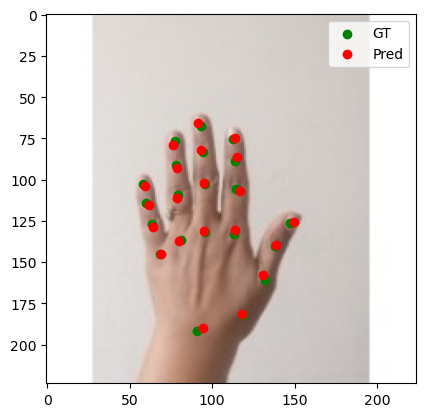

In [9]:
# Paths
img_val_dir   = f"data/images/val"
label_val_dir = f"data/labels/val"

images_test = sorted(glob.glob(f"{img_val_dir}/*.jpg", recursive = True))
labels_test = sorted(glob.glob(f"{label_val_dir}/*.txt", recursive = True))

#Test set generation
valid_numbers = random.sample(range(int(len(images_test))), int(len(images_test) / 2))
test_numbers = [i for i in range(len(images_test)) if i not in valid_numbers]

images_test = sorted([images_test[i] for i in test_numbers])
labels_test = sorted([labels_test[i] for i in test_numbers])

# Example Image
x = 0

img = cv2.imread(images_test[x])  # (H, W, 3) BGR
label = labels_test[x]

pred = inference(img)
gts = get_gt(label)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.scatter(gts[:,0], gts[:,1], c="g", label="GT")
plt.scatter(pred[:,0], pred[:,1], c="r", label="Pred")
plt.legend(); plt.show()
    

PCK@1.00px: 0.2065
PCK@3.00px: 0.6998
PCK@5.00px: 0.8377
PCK@7.00px: 0.8954
PCK@10.00px: 0.9331


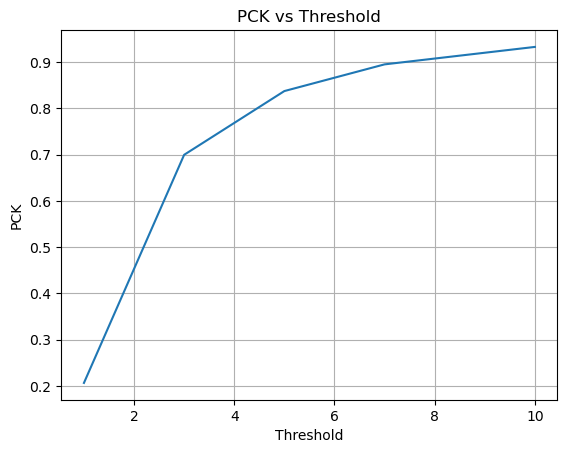

In [10]:
# pck calculation
def calculate_pck(threshold_px):
    total_correct = 0
    total_pts = 0
    for img, label in zip(images_test, labels_test):
        input = cv2.imread(img)
        kpts = inference(input)
        gts = get_gt(label)
        
        K, _ = kpts.shape
        
        dists = np.linalg.norm(kpts - gts, axis = 1)
        total_correct += (dists <= threshold_px).sum().item()
        total_pts += K
    print(f"PCK@{threshold_px:.2f}px: {total_correct / total_pts:.4f}")
    return total_correct / total_pts

thresholds = [1, 3, 5, 7, 10]
pck_results = [calculate_pck(t) for t in thresholds]

# pck visualization
plt.plot(thresholds, pck_results)
plt.xlabel("Threshold")
plt.ylabel("PCK")
plt.title("PCK vs Threshold")
plt.grid(True)
plt.show()

In [11]:
# Latency / FPS check
import time

for _ in range(15):
    _ = inference(img)

print("\nLatency Benchmarking...")
times = []
for img in images_test[:100]:
    input = cv2.imread(img)
    t0 = time.perf_counter()
    _ = inference(input)
    t1 = time.perf_counter()
    times.append((t1 - t0) * 1000)  # ms

print(f"Average Latency: {np.mean(times):.2f} ms")
print(f"Inference FPS: {1000/np.mean(times):.2f}")


Latency Benchmarking...
Average Latency: 19.35 ms
Inference FPS: 51.67


In [12]:
# real time webcam inference + flask
c_index = 0
cap = cv2.VideoCapture(c_index); assert cap.isOpened()
app = Flask(__name__)

@app.route('/')
def video_feed():
    return Response(gen_frames(), mimetype='multipart/x-mixed-replace; boundary=frame')

def gen_frames():
    _, K, Hm, Wm = out_shape
    while True:
        ok, frame = cap.read()
        if not ok: break

        inp = preprocess(frame)
        cuda.memcpy_htod_async(d_input, inp, stream)

        # ★ v3 execution
        context.execute_async_v3(stream.handle)
        
        out_host = np.empty(out_shape, dtype=out_dtype)
        cuda.memcpy_dtoh_async(out_host, d_output, stream)
        stream.synchronize()

        out_host = out_host.astype(np.float32, copy=False)
        coords= heatmap_to_coords_softarg(out_host)
        coords = coords[0]

        # heatmap -> kpts
        kpts = coords.copy()
        kpts[:,0] *= (in_w/float(Wm)); kpts[:,1] *= (in_h/float(Hm))
        Hf, Wf = frame.shape[:2]
        kpts[:,0] *= (Wf/float(in_w)); kpts[:,1] *= (Hf/float(in_h))

        annotated = draw_keypoints(frame.copy(), kpts, r=3)
        ok, buf = cv2.imencode('.jpg', annotated)
        if not ok: continue
        yield (b'--frame\r\nContent-Type: image/jpeg\r\n\r\n'+buf.tobytes()+b'\r\n')

if __name__ == "__main__":
    try:
        print("[TRT10] in/out:", in_name, out_name)
        print("[TRT10] in shape/dtype:", context.get_tensor_shape(in_name), in_dtype)
        print("[TRT10] out shape/dtype:", out_shape, out_dtype)
        app.run(host="0.0.0.0", port=8000, debug=False, use_reloader=False)
    finally:
        cap.release(); cv2.destroyAllWindows()

[TRT10] in/out: input output
[TRT10] in shape/dtype: (1, 3, 224, 224) <class 'numpy.float32'>
[TRT10] out shape/dtype: (1, 21, 112, 112) <class 'numpy.float32'>
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8000
 * Running on http://172.30.1.50:8000
Press CTRL+C to quit
172.30.1.93 - - [04/Sep/2025 23:12:24] "GET / HTTP/1.1" 200 -
